In [7]:
import warnings

warnings.filterwarnings(action='ignore')

import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from torch import nn
from torch.utils.data import random_split, DataLoader
from forest_cover_change_detection.dataloaders.change import ChangeDetectionDataset
from forest_cover_change_detection.models.fc_ef import FCFE
from forest_cover_change_detection.trainer.train import Compile
from forest_cover_change_detection.metrics.accuracy import *

### Loading Data

In [2]:
data_set = ChangeDetectionDataset('../data/annotated',
                                  '../data/train.csv',
                                  concat=False
                                  )

In [3]:
len(data_set)

334

(-0.5, 255.5, 255.5, -0.5)

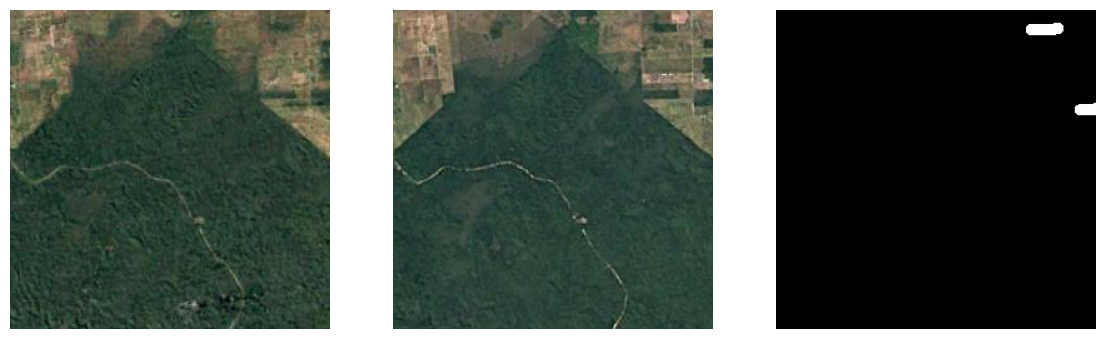

In [4]:
img1, img2, label = data_set[np.random.randint(0, data_set.__len__())]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 8), dpi=100)
axes = axes.ravel()

axes[0].imshow(img1.permute(1, 2, 0).numpy())
axes[1].imshow(img2.permute(1, 2, 0).numpy())
axes[2].imshow(label.numpy(), cmap='gray')

axes[0].axis(False)
axes[1].axis(False)
axes[2].axis(False)

In [64]:
patch_side = 96
stride = int(patch_side / 2) - 1
n_pix = 0
true_pix = 0
n_patches = 0

s = label.shape
n_pix += np.prod(s)
true_pix += label.sum()

In [65]:
s = img1.shape
n1 = math.ceil((s[1] - patch_side + 1) / stride)
n2 = math.ceil((s[2] - patch_side + 1) / stride)
n_patches_i = n1 * n2
n_patches += n_patches_i

In [66]:
n1, n2

(4, 4)

In [67]:
patch_coords = []

for i in range(n1):
    for j in range(n2):
        # coordinates in (x1, x2, y1, y2)
        current_patch_coords = ([stride * i, stride * i + patch_side, stride * j, stride * j + patch_side],
                                [stride * (i + 1), stride * (j + 1)])
        patch_coords.append(current_patch_coords)

In [78]:
patch_coords

[([0, 96, 0, 96], [47, 47]),
 ([0, 96, 47, 143], [47, 94]),
 ([0, 96, 94, 190], [47, 141]),
 ([0, 96, 141, 237], [47, 188]),
 ([47, 143, 0, 96], [94, 47]),
 ([47, 143, 47, 143], [94, 94]),
 ([47, 143, 94, 190], [94, 141]),
 ([47, 143, 141, 237], [94, 188]),
 ([94, 190, 0, 96], [141, 47]),
 ([94, 190, 47, 143], [141, 94]),
 ([94, 190, 94, 190], [141, 141]),
 ([94, 190, 141, 237], [141, 188]),
 ([141, 237, 0, 96], [188, 47]),
 ([141, 237, 47, 143], [188, 94]),
 ([141, 237, 94, 190], [188, 141]),
 ([141, 237, 141, 237], [188, 188])]

In [68]:
weights = [10 * 2 * true_pix / n_pix, 2 * (n_pix - true_pix) / n_pix]
weights

[tensor(0.1245), tensor(1.9875)]

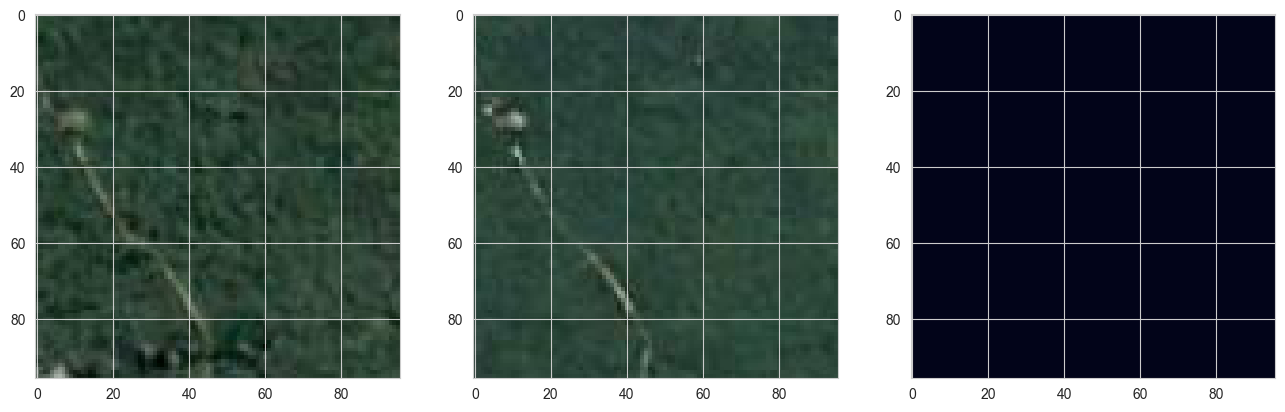

In [77]:
limits, centers = patch_coords[np.random.randint(0, len(patch_coords))]

plt.figure(figsize=(16, 10))
plt.subplot(1, 3, 1)
plt.imshow(img1[:, limits[0]:limits[1], limits[2]:limits[3]].permute(1, 2, 0).numpy())
plt.subplot(1, 3, 2)
plt.imshow(img2[:, limits[0]:limits[1], limits[2]:limits[3]].permute(1, 2, 0).numpy())
plt.subplot(1, 3, 3)
plt.imshow(label[limits[0]:limits[1], limits[2]:limits[3]].numpy())

In [ ]:
train_size = int(len(data_set) * 0.8)
test_size = len(data_set) - train_size

train_dataset, test_dataset = random_split(data_set, (train_size, test_size))

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
next(iter(train_dataloader))[0].shape, next(iter(train_dataloader))[1].shape

### Modeling

In [ ]:
model = FCFE(6, 3, classes=2)

In [ ]:
optimizer = AdamW(model.parameters(), lr=0.001)
scheduler = OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_dataloader), epochs=200)

compiled = Compile(model,
                   optimizer,
                   lr_scheduler=scheduler
                   )

In [ ]:
compiled.summary((6, 256, 256))

In [ ]:
results = compiled.train(train_dataloader,
                         nn.NLLLoss(),
                         200,
                         test_dataloader)

In [ ]:
torch.save(model, "../checkpoints/fcfe/final-model.pth")

In [ ]:
plt.figure(figsize=[12, 6], dpi=200)
sns.lineplot(x='epoch', y='train loss', data=results, label='train')
sns.lineplot(x='epoch', y='val loss', data=results, label='validation')
plt.show()

In [ ]:
i = np.random.randint(0, len(test_dataset))
img = test_dataset[i][0]

with torch.no_grad():
    model.eval()
    logits = model(img.unsqueeze(0).to('cuda'))[0].cpu()
    pred = torch.argmax(torch.sigmoid(logits), dim=0)

plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.imshow(test_dataset[i][1], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(pred, cmap='gray')

In [ ]:
pixel_accuracy(test_dataset[i][1], pred), kappa(test_dataset[i][1], pred)